# <font color="RoyalBlue">Energy Price Prediction - Introduction</font>

This project is part of a university course and focuses on <b>predicting electricity prices</b> using Python and Jupyter Notebooks. For now, only the hourly <b>EPEX SPOT day-ahead prices of germany</b> are covered. After a quick data analysis, several machine learning and time series models (SARIMA, Prophet, XGBoost, LSTM) are trained, evaluated and finally compared.

Table of Contents of this Notebook:
1) Importing Libraries
2) Loading and Describing the Data
3) Exploratory Data Analysis (EDA)
4) Data Preparation
5) Feature Engineering
6) Model Training and Prediction
7) Model Evaluation and Comparison
8) Conclusion

## <font color="RoyalBlue">1 Importing Libraries</font>
Import all necessary libraries required for data analysis, machine learning models and data visualization. This is also where we can set a plot design applied for Seaborn and Pyplot.

In [1]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Time Series Models
from xgboost import XGBRegressor
import xgboost as xgb
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Scikit-Learn Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Holidays
import holidays

# Time and Date
import datetime

# Simple plot design
print(plt.style.available)
sns.set_style('darkgrid')
sns.set_palette("bright")


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


Sample Plot (delete later, this is just for design)

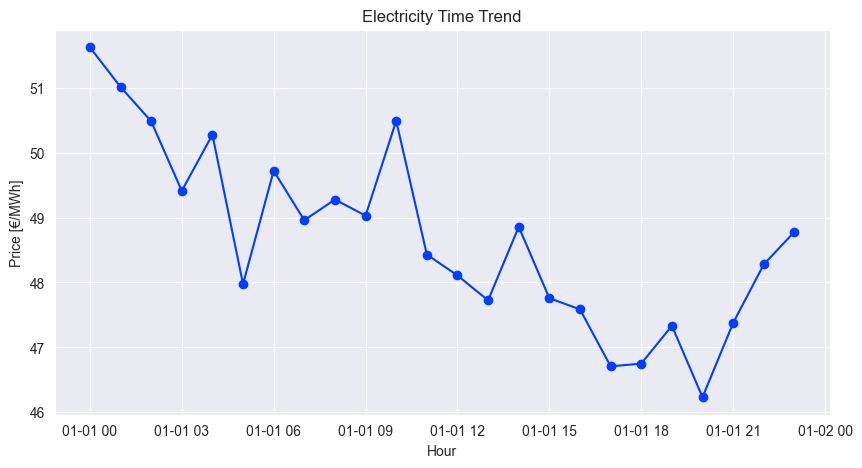

In [2]:
# some random price data for 24 hours
np.random.seed(1) 
hours = pd.date_range(start="2024-01-01", periods=24, freq="h")
prices = 50 + np.random.randn(24).cumsum() 

df = pd.DataFrame({"Hour": hours, "Price": prices})

# plot the data
plt.figure(figsize=(10, 5))
plt.plot(df["Hour"], df["Price"], marker='o')
plt.title("Electricity Time Trend")
plt.xlabel("Hour")
plt.ylabel("Price [€/MWh]")
plt.grid(True)
plt.show()



## <font color="RoyalBlue">2 Loading and Describing the Data</font>

First of all, load the data of the csv files. We use different csv files and join them together by date and hour. After that, we print out some basic information of our data.


In [3]:
# Read csv
df = pd.read_csv("../data/germany_epex_spot.csv")

# TODO: add more data sources

After loading in the data, we can construct some Pandas DataFrames.

<Axes: title={'center': 'Data Frame'}, xlabel='Datetime (Local)'>

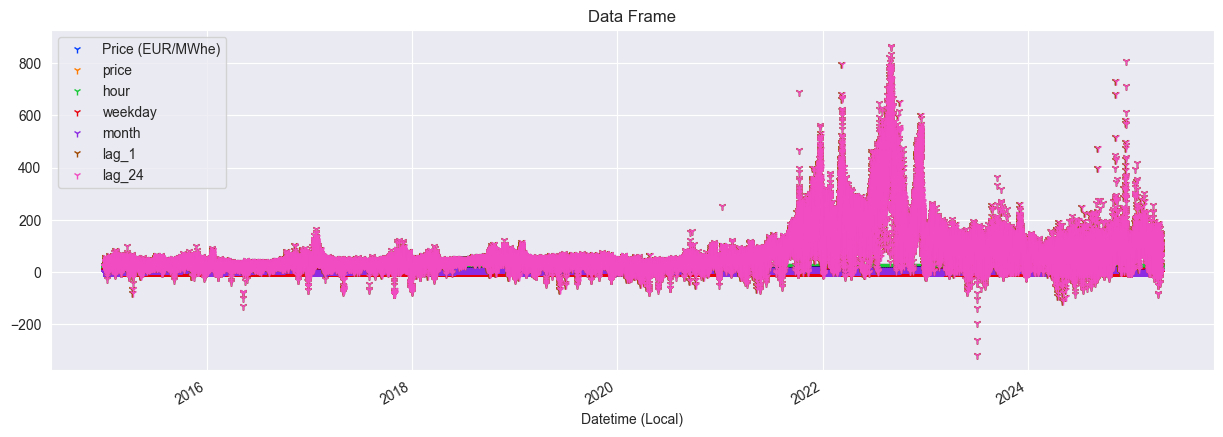

In [4]:
# convert local time in datetime object and set as index
df["Datetime (Local)"] = pd.to_datetime(df["Datetime (Local)"])
df = df.set_index("Datetime (Local)")
df = df.sort_index()

# target variable
df["price"] = df["Price (EUR/MWhe)"]

# time based features
df["hour"] = df.index.hour
df["weekday"] = df.index.weekday
df["month"] = df.index.month

# lag features (price 1h and 24h before)
df["lag_1"] = df["price"].shift(1)
df["lag_24"] = df["price"].shift(24)
# TODO: maybe more? What is best?

df.plot(style="1", figsize=(15, 5), title="Data Frame")

# TODO: update and clean this code after new data sets are loaded in


Print out some basic information about our data

In [5]:
df.head()
# df.tail()

# TODO: do this for all our data frames when new data sets are available

,Country,ISO3 Code,Datetime (UTC),Price (EUR/MWhe),price,hour,weekday,month,lag_1,lag_24
Datetime (Local),,,,,,,,,,
2015-01-01 01:00:00,Germany,DEU,2015-01-01 00:00:00,22.34,22.34,1,3,1,NaN,NaN
2015-01-01 02:00:00,Germany,DEU,2015-01-01 01:00:00,22.34,22.34,2,3,1,22.34,NaN
2015-01-01 03:00:00,Germany,DEU,2015-01-01 02:00:00,22.34,22.34,3,3,1,22.34,NaN
2015-01-01 04:00:00,Germany,DEU,2015-01-01 03:00:00,22.34,22.34,4,3,1,22.34,NaN
2015-01-01 05:00:00,Germany,DEU,2015-01-01 04:00:00,22.34,22.34,5,3,1,22.34,NaN


TODO: explain negative electricity prices very briefly here and print some examples

## <font color="RoyalBlue">3 Exploratory Data Analysis (EDA)</font>
In this section, we explore and visualize the data to better understand patterns and correlation. This is done before handling NaN values and outliers.

TODO: add small summary for each plot
- Price over Time
- Correlation of the featuers (maybe with sns.heatmap)
- Plot and explain seasonal patterns
- Plot the target variable over time
- more ... ?

### Price over Time

In [6]:
# TODO: plot price over time

### Correlation of the features

In [7]:
# TODO: sns.heatmap()

## <font color="RoyalBlue">4 Data Preparation</font>
This section prepares the data by handling missing values, removing duplicates and transforming data types (TODO: remove last part of sentence if no transformation needed later). This is also a good place to remove unnecessary features that may have a negative impact on the models prediction.

In [8]:
# remove rows with NaN (because of shift)

nan_amount_before = 20 # TODO -> df.isna().sum()
print("amount of NaN values before cleanup: {}".format(nan_amount_before))
df = df.dropna()
nan_amount_after = 0 # TODO
print("amount of NaN values after cleanup: {}".format(nan_amount_after))

nan_amount_removed = nan_amount_before - nan_amount_after
print("So we removed {} NaN values".format(nan_amount_removed))


amount of NaN values before cleanup: 20
amount of NaN values after cleanup: 0
So we removed 20 NaN values


TODO: maybe scaling / normalising needed for numerical features?

In [9]:
# TODO: scale or normalize values if this achieves better performance

## <font color="RoyalBlue">5 Feature Engineering</font>
Here, we can use our conclusions of the EDA by defining our feature set and the target variable that is to predict. In this regard, we will also create some new features that can be used for training in order to gain a better performance out of the models.

Lastly, we split our data into train and test data. Note, that when using time series data like we do, we should not split randomly, but by date instead.

TODO: maybe explain the term "lags"

In [10]:
# Create some new features

# TODO: calendar features (hour, weekday, month)
# TODO: add holiday features

In [11]:
# Define feature set and target variable 
features = ["hour", "weekday", "month", "lag_1", "lag_24"] # lags used for 
X = df[features]
y = df["price"]

Now we split our data into train and test data. We need to make sure that the data is not split randomly, but instead chronologically, so that the model is trained on past data and tested on future data only. This avoids so called "Data Leakage".

In this case, we split by 80:20 for Training and Test data.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# For X_train
print("X_train:")
print("  Lines:", len(X_train))
print("  Span:", X_train.index.min(), "until", X_train.index.max())

# For X_test
print("X_test:")
print("  Lines:", len(X_test))
print("  Span:", X_test.index.min(), "Span", X_test.index.max())

# For y_train
print("y_train:")
print("  Lines:", len(y_train))
print("  Span:", y_train.index.min(), "Span", y_train.index.max())

# For y_test
print("y_test:")
print("  Lines:", len(y_test))
print("  Span:", y_test.index.min(), "Span", y_test.index.max())

X_train:
  Lines: 72145
  Span: 2015-01-02 01:00:00 until 2023-03-27 02:00:00
X_test:
  Lines: 18037
  Span: 2023-03-27 03:00:00 Span 2025-04-16 22:00:00
y_train:
  Lines: 72145
  Span: 2015-01-02 01:00:00 Span 2023-03-27 02:00:00
y_test:
  Lines: 18037
  Span: 2023-03-27 03:00:00 Span 2025-04-16 22:00:00


## <font color="RoyalBlue">6 Model Training and Prediction</font>
In this section, we ... TODO

TODO: use different data for each model (SARIMA, Prophet, XGBoost, LSTM)?

TODO: add a section for each model

### Create and train model (only XGBRegressor for now)

In [13]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### Predict and evaluate

In [18]:
y_pred = model.predict(X_test)

# TODO: do evaluation in section 7 below 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f} EUR/MWh")

RMSE: 13.30 EUR/MWh


## <font color="RoyalBlue">7 Model Evaluation and Comparison</font>
TODO: add description

Plot real prices against the predicted prices for each model (probably best to do this in one plot only)

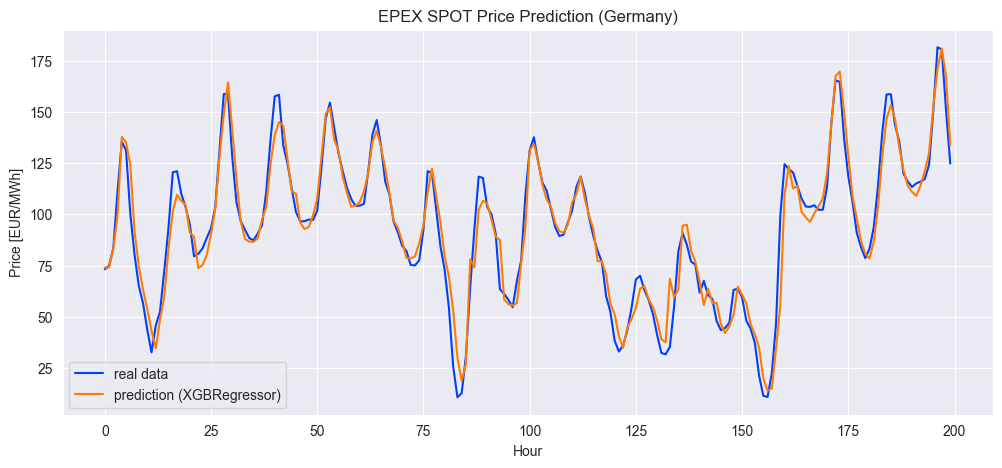

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:200], label="real data")
plt.plot(y_pred[:200], label="prediction (XGBRegressor)")
plt.legend()
plt.title("EPEX SPOT Price Prediction (Germany)")
plt.xlabel("Hour")
plt.ylabel("Price [EUR/MWh]")
plt.show()

TODO: Print relevant evaluation metrics for eacht model (MAE, RMSE, MAPE) and explain them briefly.


## <font color="RoyalBlue">8 Conclusion</font>
TODO: add:
- which model performs the best? Why? 
- What errors / short cuts may have been made in this project? How does it impact the outcome?
- do certain models show specific weaknesses (for example especially bad predictions on holidays)